# 1. Setup

In [1]:
import sys
sys.path.append('../..')
from mobiquity.names import *

In [2]:
zones10 = U.load(DATA / 'zones/in_2010.parquet').disp()
zones20 = U.load(DATA / 'zones/in_2020.parquet').disp(0)

6,417 rows x 9 cols; Memory: 1.0 MiB; <Projected CRS: EPSG:3857>


,geoid,scale,county,urba,top_msa,msa,aland,awater,geometry
,<object>,<category>,<category>,<category>,<bool>,<category>,<float32>,<float32>,<geometry>
0,18001,County,Adams,"Decatur, IN",False,NaN,339.026642,0.938403,"POLYGON ((-9440153.084239 4962095.689279, -944..."


7,078 rows x 9 cols; Memory: 1.0 MiB; <Projected CRS: EPSG:3857>


,geoid,scale,county,urba,top_msa,msa,aland,awater,geometry
,<object>,<category>,<category>,<category>,<bool>,<category>,<float32>,<float32>,<geometry>


# 2. PLACES data
PLACES: Local Data for Better Health, downloaded from https://data.cdc.gov/500-Cities-Places/PLACES-Local-Data-for-Better-Health-Census-Tract-D/cwsq-ngmh/about_data.

The main file is renamed to `places_tract_2023.csv`.

## 2.1. Process

In [3]:
cols = ( # (column_name, new_column_name, type)
    # ('Year', 'year', CAT),
    ('StateAbbr', 'state_id', CAT),
    # ('StateDesc', 'state', CAT),
    # ('CountyName', 'county', CAT),
    # ('CountyFIPS', 'county_id', CAT),
    ('LocationName', 'geoid', CAT),
    # ('DataSource', 'data_src', CAT),
    ('Category', 'category', CAT),
    ('Measure', 'measure', CAT),
    # ('Data_Value_Unit', 'unit', CAT),
    # ('Data_Value_Type', 'dtype', CAT),
    ('Data_Value', 'value', F32),
    # ('Data_Value_Footnote_Symbol', 'footnote', CAT),
    ('Low_Confidence_Limit', 'low', F32),
    ('High_Confidence_Limit', 'high', F32),
    ('TotalPopulation', 'popu', F32),
    # ('Geolocation', 'geom_wkt', CAT),
    # ('LocationID', 'geoid', CAT),
    # ('CategoryID', 'category_id', CAT),
    ('MeasureId', 'measure_id', CAT),
    # ('DataValueID', 'value_id', CAT),
    ('Short_Question_Text', 'question', CAT),
)

In [4]:
places = (
    U.load(DATA / 'equity_atlas/health/places_tract_2023.csv',
           usecols=[x[0] for x in cols], dtype={x[0]: x[2] for x in cols})
    .rename(columns={x[0]: x[1] for x in cols})
    .query('state_id == "IN"').drop(columns='state_id')
    .assign(measure_id=lambda df: df.measure_id.str.lower())
    .reset_index(drop=1).astype(D(geoid=str))
).disp() # 5s

55,676 rows x 9 cols; Memory: 8.0 MiB


,geoid,category,measure,value,low,high,popu,measure_id,question
,<object>,<category>,<category>,<float32>,<float32>,<float32>,<float32>,<object>,<category>
0,18015959300,Health Outcomes,Stroke among adults aged >=18 years,3.4,3.1,3.8,3023.0,stroke,Stroke


In [5]:
data10 = (places.pivot_table('value', 'geoid', 'measure_id').fillna(0) / 100).disp()

1,505 rows x 37 cols; Memory: 0.3 MiB


measure_id,access2,arthritis,binge,bphigh,bpmed,cancer,casthma,cervical,chd,checkup,...,mammouse,mhlth,mobility,obesity,phlth,selfcare,sleep,stroke,teethlost,vision
geoid,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,...,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>
18001030100,0.068,0.278,0.171,0.324,0.788,0.072,0.1,0.833,0.057,0.739,...,0.702,0.152,0.119,0.363,0.108,0.029,0.328,0.028,0.124,0.035


In [6]:
data10.describe().loc[['min', '50%', 'max']]

measure_id,access2,arthritis,binge,bphigh,bpmed,cancer,casthma,cervical,chd,checkup,...,mammouse,mhlth,mobility,obesity,phlth,selfcare,sleep,stroke,teethlost,vision
min,0.031,0.047,0.094,0.111,0.246,0.007,0.085,0.415,0.009,0.607,...,0.000,0.100,0.035,0.228,0.049,0.009,0.244,0.007,0.000,0.019
50%,0.089,0.280,0.162,0.344,0.791,0.069,0.107,0.813,0.063,0.747,...,0.721,0.169,0.147,0.382,0.124,0.038,0.346,0.032,0.173,0.048
max,0.321,0.414,0.243,0.594,0.876,0.113,0.188,0.887,0.135,0.835,...,0.836,0.345,0.348,0.582,0.233,0.153,0.510,0.090,0.486,0.196


### 2.1.1. Map data from 2010 to 2020

In [7]:
map10to20 = (
    U.load(DATA / 'zones/crosstab_2010_2020.parquet')
    .assign(state=lambda df: df.geoid10.str[:2])
    .query('state == "18" & scale == "Tract"')
    .pivot_table('aland_part', 'geoid10', 'geoid20')
    .loc[data10.index].fillna(0).apply(lambda r: r / r.sum(), axis=1)
).disp()

1,505 rows x 1,697 cols; Memory: 19.6 MiB


geoid20,18001030100,18001030200,18001030300,18001030400,18001030500,18001030600,18001030700,18003000100,18003000300,18003000400,...,18181958800,18183050100,18183050200,18183050300,18183050401,18183050402,18183050500,18183050600,18183050700,21101020604
geoid,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,...,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>
18001030100,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
data20 = (Pdf(map10to20.values.T @ data10.values,
              columns=data10.columns, index=map10to20.columns)
          .rename_axis('geoid')).disp()
data20.to_csv(DATA / 'equity_atlas/health/places_in_2020.csv')

1,697 rows x 37 cols; Memory: 0.7 MiB


measure_id,access2,arthritis,binge,bphigh,bpmed,cancer,casthma,cervical,chd,checkup,...,mammouse,mhlth,mobility,obesity,phlth,selfcare,sleep,stroke,teethlost,vision
geoid,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,...,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>
18001030100,0.068,0.278,0.171,0.324,0.788,0.072,0.1,0.833,0.057,0.739,...,0.702,0.152,0.119,0.363,0.108,0.029,0.328,0.028,0.124,0.035


## 2.2. Measures

In [9]:
measures = (places.groupby(['category', 'measure_id', 'question', 'measure'])
            .size().pipe(lambda x: x[x > 0]).reset_index()
            .drop(columns=0)).disp(None)
measures.to_csv(DATA / 'equity_atlas/health/places_data_dict.csv', index=False)

37 rows x 4 cols; Memory: 0.0 MiB


,category,measure_id,question,measure
,<category>,<object>,<category>,<category>
0,Disability,cognition,Cognitive Disability,Cognitive disability among adults ages >=18 years
1,Disability,disability,Any Disability,Any disability among adults aged >=18 years
2,Disability,hearing,Hearing Disability,Hearing disability among adults aged >=18 years
3,Disability,indeplive,Independent Living Disability,Independent living disability among adults age...
4,Disability,mobility,Mobility Disability,Mobility disability among adults aged >=18 years
5,Disability,selfcare,Self-care Disability,Self-care disability among adults aged >=18 years
6,Disability,vision,Vision Disability,Vision disability among adults aged >=18 years
7,Health Outcomes,arthritis,Arthritis,Arthritis among adults aged >=18 years
8,Health Outcomes,bphigh,High Blood Pressure,High blood pressure among adults aged >=18 years


## 2.3. Prepare relevant columns

In [10]:
def get_imp_health_data(data, zones):
    df = data.reset_index().rename(columns=D(
        access2='insur', casthma='asthma', disability='disabl'))
    df['health'] = df[('arthritis bphigh chd copd depression diabetes '
                       'highchol obesity stroke teethlost').split()].mean(1)
    df['risk'] = df[['csmoking', 'lpa', 'sleep']].mean(1)
    df['prevent'] = df[('bpmed cervical checkup cholscreen '
                        'colon_screen corem corew dental').split()].mean(1)
    tract = df['geoid health asthma cancer copd disabl risk insur prevent'.split()]
    cnty = (tract.assign(geoid=df.geoid.str[:5]).set_index('geoid')
            .groupby('geoid').mean().reset_index())
    bg = (U.filt(zones, scale='BG')[['geoid']]
          .assign(tract_id=lambda df: df.geoid.str[:11])
          .merge(tract.rename(columns=D(geoid='tract_id')))
          .drop(columns='tract_id'))
    for scale, df in D(Tract=tract, County=cnty, BG=bg).items():
        df.insert(1, 'scale', scale)
    df = pd.concat([cnty, tract, bg]).reset_index(drop=1)
    return df

hlth10 = get_imp_health_data(data10, zones10).disp(0)
hlth20 = get_imp_health_data(data20, zones20).disp()
hlth20.to_parquet(DATA / 'equity_atlas/health/health.parquet')

6,405 rows x 10 cols; Memory: 1.0 MiB


,geoid,scale,health,asthma,cancer,copd,disabl,risk,insur,prevent
,<object>,<object>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>


7,080 rows x 10 cols; Memory: 1.3 MiB


,geoid,scale,health,asthma,cancer,copd,disabl,risk,insur,prevent
,<object>,<object>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>
0,18001,County,0.217929,0.110429,0.072714,0.097714,0.326857,0.282476,0.103143,0.644625


# 3. Visualize

## 3.1. Health measure map

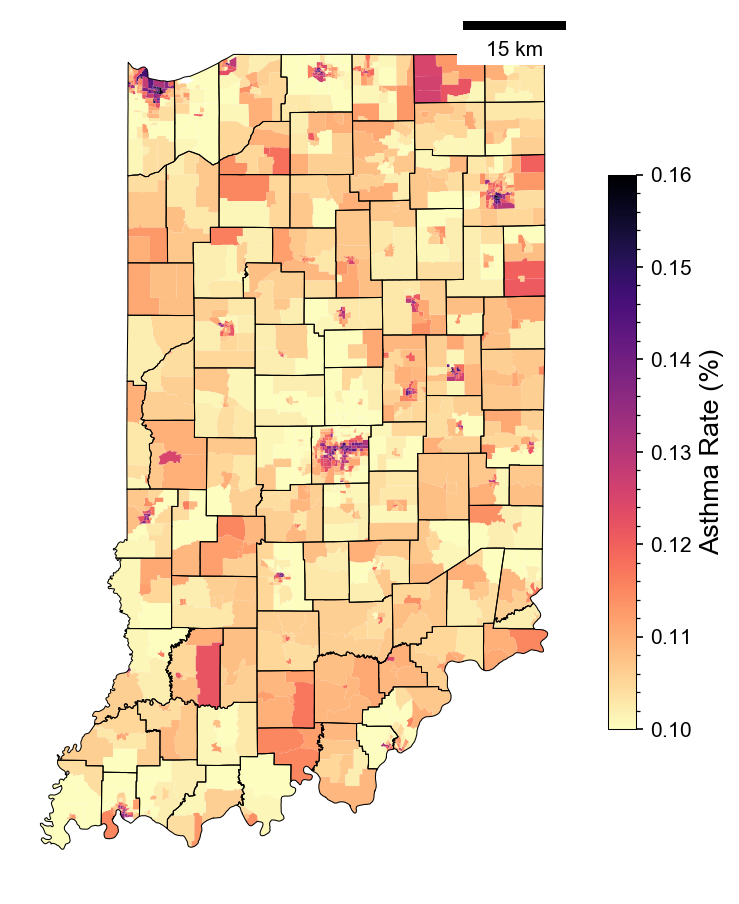

In [11]:
ax = U.plot(size=(6, 12), dpi=150, axoff=1)
df = zones10.merge(data10, on='geoid')
ax = U.maplot(df, 'casthma', ax, cmap='magma_r', basemap=None,
              vmin=.10, vmax=.16, label='Asthma Rate (%)', shrink=0.4)
U.filt(zones10, scale='County').plot(ax=ax, fc='none', ec='k', lw=0.5)
U.imsave('Asthma prevalence in Indiana (PLACES)')

## 3.2. Correlation

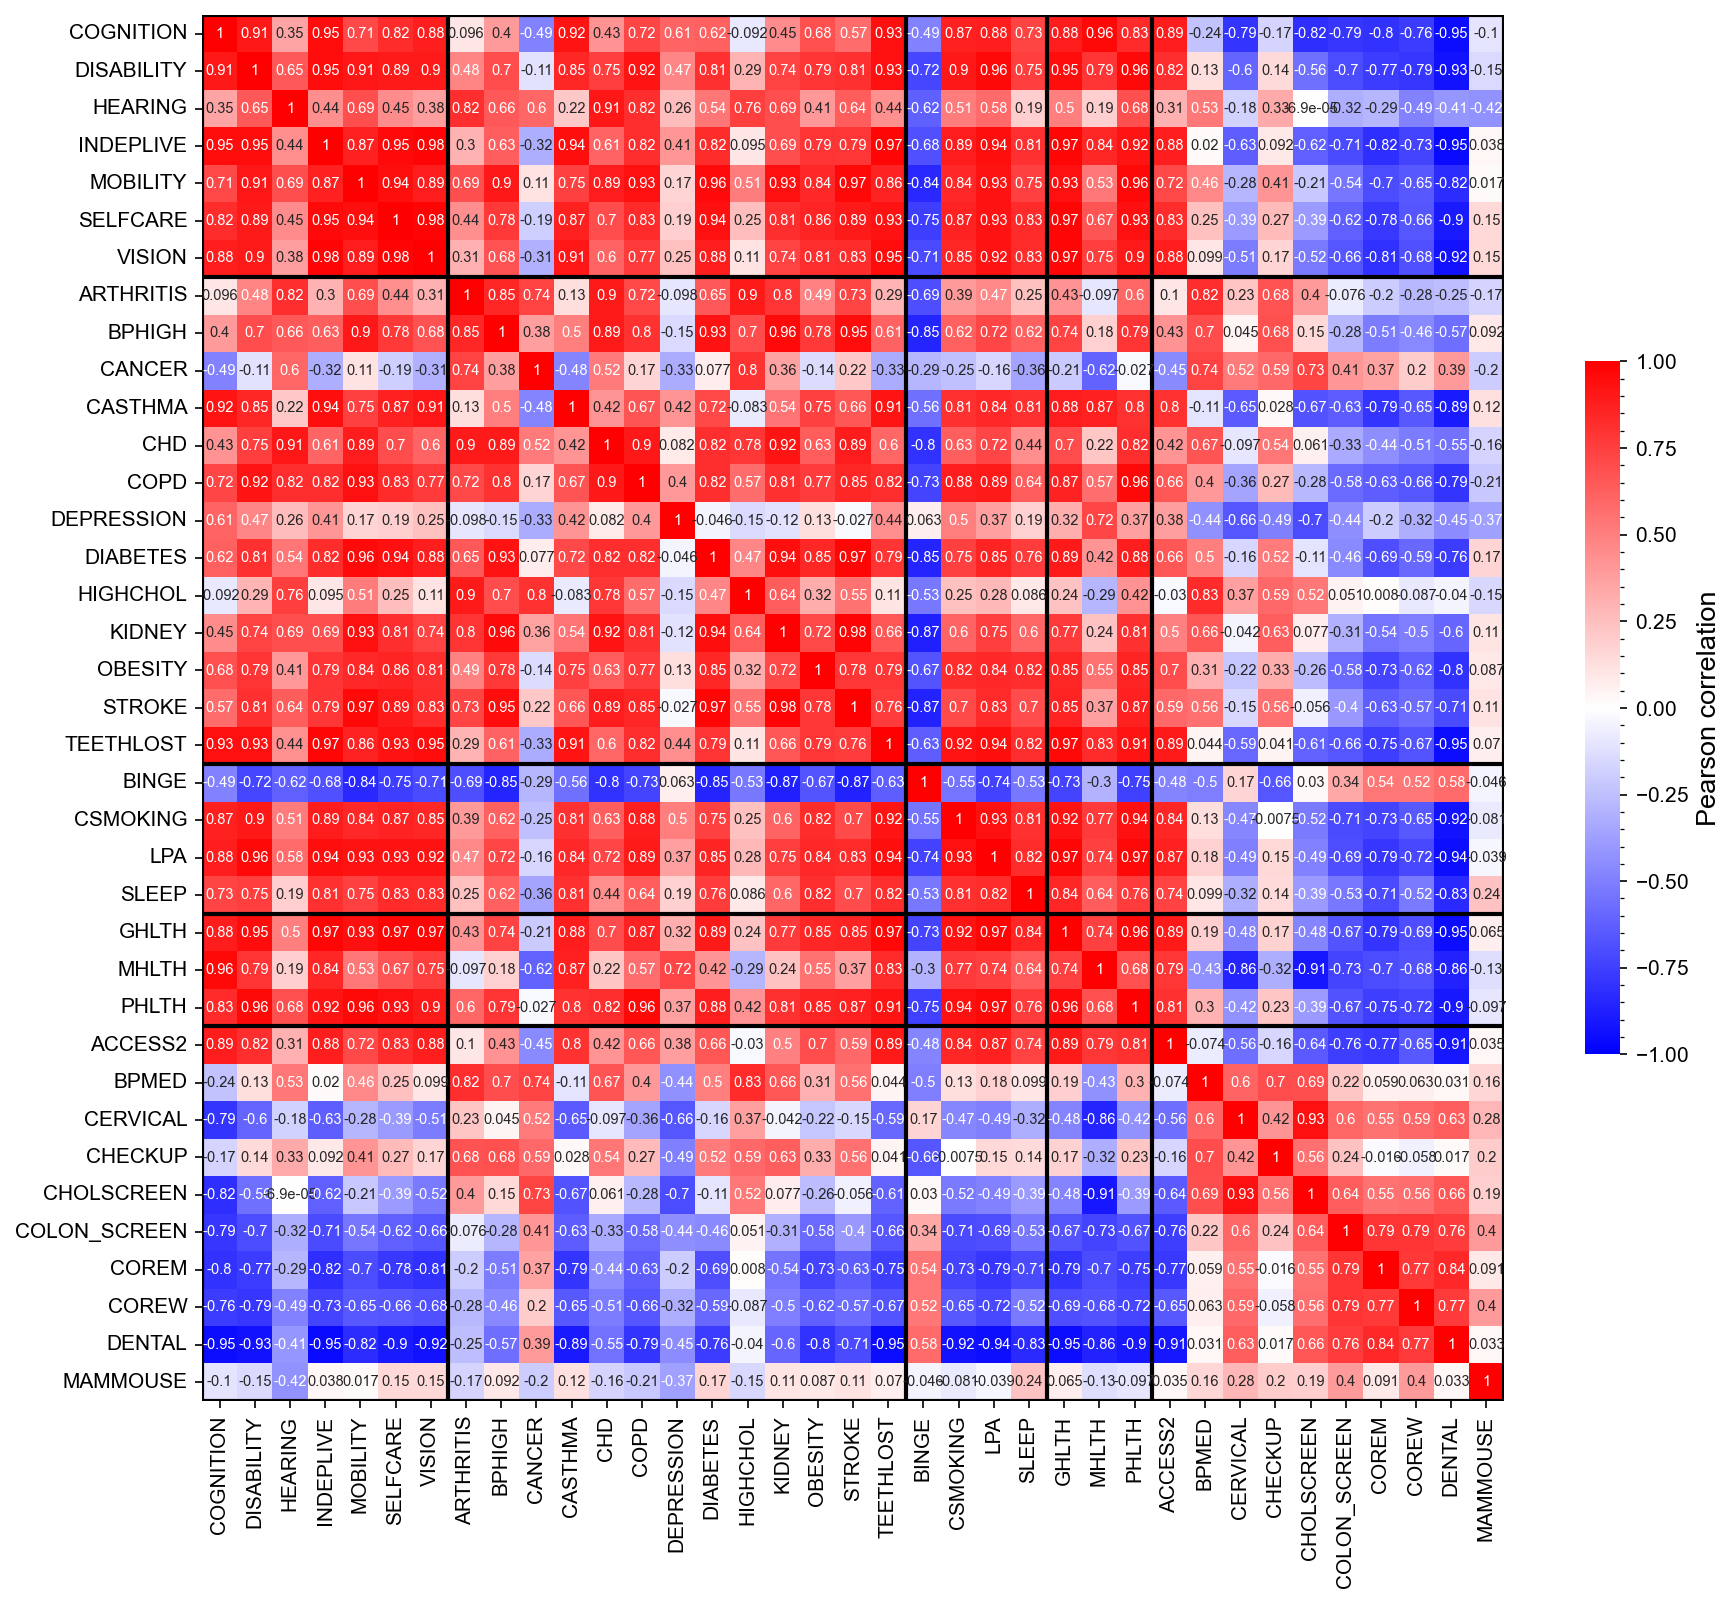

In [12]:
ax = U.plot(size=(14, 12), dpi=150, xminor=0, yminor=0, gridcolor='none')
sns.heatmap(data10[measures.measure_id].rename(columns=str.upper).corr(),
            ax=ax, cmap='bwr', center=0, vmin=-1, vmax=1, cbar_kws=D(
                shrink=0.5, label='Pearson correlation'),
            annot=True, annot_kws=D(fontsize=7))
for i in list(measures.drop_duplicates('category').index) + [len(measures)]:
    ax.axvline(i, color='k', lw=2)
    ax.axhline(i, color='k', lw=2)
ax.set_xlabel(''); ax.set_ylabel('')
U.imsave('Correlation of PLACES health variables') # 6s

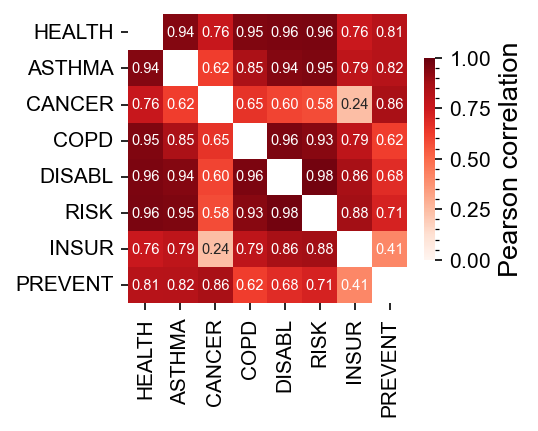

In [13]:
ax = U.plot(size=(3, 2.5), dpi=150, xminor=0, yminor=0, gridcolor='none')
corr = (U.filt(hlth20, scale='Tract').set_index('geoid')
        .rename(columns=str.upper).corr())
np.fill_diagonal(corr.values, np.nan)
sns.heatmap(corr, ax=ax, cmap='Reds', vmax=1, vmin=0,
            annot=True, fmt='.2f', annot_kws=D(fontsize=7),
            cbar_kws=D(shrink=0.7, label='Pearson correlation'))
ax.set_xlabel(''); ax.set_ylabel('')
U.imsave('Correlation of relevant health variables')

## 3.3. Relationship with SES

In [14]:
ses = U.filt(U.load(DATA / 'ses/ses.parquet'), scale='Tract')
ses = ses[ses.geoid.str[:2] == '18'].set_index('geoid')
ses['p_altmode'] = ses.p_transit + ses.p_walkbike
ses_cols = D(popu='popu', pop_density='popd', house_density='housd', p_poc='poc',
             p_snap='snap', m_income='incm', p_lowedu='educ', p_loweng='engl',
             p_noinsur='insur', p_disabled='disbl', p_snglparent='parent1',
             p_noveh='noveh', m_hhperveh='hhveh', p_altmode='altmode')
ses = ses[list(ses_cols)].rename(columns=ses_cols).disp()

1,687 rows x 14 cols; Memory: 0.2 MiB


,popu,popd,housd,poc,snap,incm,educ,engl,insur,disbl,parent1,noveh,hhveh,altmode
geoid,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>
18001030100,4826.0,62.160343,62.160343,0.067758,0.013194,0.164377,0.406098,0.0,0.057605,0.280374,0.091248,0.009896,0.857614,0.014865


In [15]:
imp_health_df = data20[(
    'mobility arthritis bphigh cancer casthma chd depression '
    'diabetes highchol obesity stroke lpa sleep ghlth mhlth '
    'phlth access2 checkup cholscreen dental').split()].disp()

1,697 rows x 20 cols; Memory: 0.4 MiB


measure_id,mobility,arthritis,bphigh,cancer,casthma,chd,depression,diabetes,highchol,obesity,stroke,lpa,sleep,ghlth,mhlth,phlth,access2,checkup,cholscreen,dental
geoid,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>
18001030100,0.119,0.278,0.324,0.072,0.1,0.057,0.244,0.099,0.345,0.363,0.028,0.227,0.328,0.142,0.152,0.108,0.068,0.739,0.85,0.703


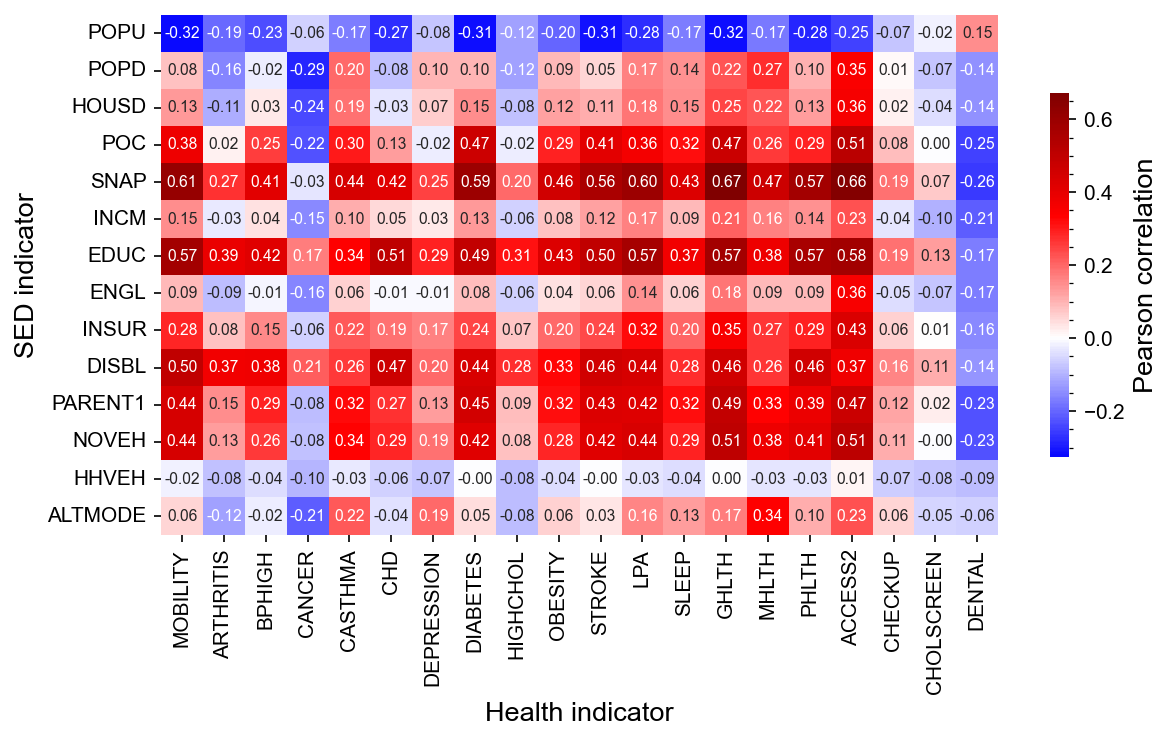

In [16]:
corr = imp_health_df.merge(ses, on='geoid').corr()
corr = corr.loc[ses.columns, imp_health_df.columns]
corr = corr.rename(index=str.upper, columns=str.upper)
ax = U.plot(size=(9, 4.5), dpi=150, xminor=0, yminor=0, gridcolor='none')
sns.heatmap(corr, ax=ax, cmap='seismic', center=0,
            annot=True, fmt='.2f', annot_kws=D(fontsize=7.5),
            cbar_kws=D(shrink=0.7, label='Pearson correlation'))
ax.set_xlabel('Health indicator')
ax.set_ylabel('SED indicator')
U.imsave('Correlation between SES and health variables')